# TF-IDF and SVM classification

In [1]:
# preprocessing & utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# text handling 
import nltk
import re
import spacy
import string
from nltk.corpus import stopwords

# models for classification
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Functions

In [3]:
def plot_cm(pipeline, X_test, y_test):
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(pipeline, X_test, y_test, cmap="YlGnBu")  
    plt.xticks(rotation=45, fontsize = 10)
    plt.yticks(rotation=0, fontsize = 8)
    plt.title("Confusion matrix")
    plt.show()
    
def eval_accuracy (pred, test):
    correct = 0
    for prediction,true_label in zip(predictions, y_test):
        if prediction==true_label:
            correct += 1
    return (correct/len(predictions))

In [4]:
df = pd.read_csv("data/books_def_small.csv", index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26484 entries, Suzanne Collins to Mimi Baird|Eve Claxton
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   book_desc    26484 non-null  object 
 1   book_rating  26484 non-null  float64
 2   book_title   26484 non-null  object 
 3   genres       26484 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.0+ MB


In [6]:
df.head()

,book_desc,book_rating,book_title,genres
book_authors,,,,
Suzanne Collins,Winning will make you famous. Losing means cer...,4.33,The Hunger Games,Young Adult
J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,4.48,Harry Potter and the Order of the Phoenix,Fantasy
Harper Lee,The unforgettable novel of a childhood in a sl...,4.27,To Kill a Mockingbird,Classics
Stephenie Meyer,About three things I was absolutely positive.F...,3.58,Twilight,Young Adult
Markus Zusak,Trying to make sense of the horrors of World W...,4.36,The Book Thief,Historical


In [7]:
df = df.reset_index()

In [8]:
df["book_desc"]

0        Winning will make you famous. Losing means cer...
1        There is a door at the end of a silent corrido...
2        The unforgettable novel of a childhood in a sl...
3        About three things I was absolutely positive.F...
4        Trying to make sense of the horrors of World W...
                               ...                        
26479    Thirteen-year-old Jasira wants what every girl...
26480    A brilliant, provocative novel about an artist...
26481    Avi Steinberg is stumped. After defecting from...
26482    From the icons of the game to the players who ...
26483    Soon to be a major motion picture, from Brad P...
Name: book_desc, Length: 26484, dtype: object

In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
# leggo testi & etichette
X = df["book_desc"]
y = df["genres"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=1)

In [11]:
sample_idx = 50
X_train[sample_idx]

"Selected by the Modern Library as one of the 100 best novels of all time, Slaughterhouse-Five, an American classic, is one of the world's great antiwar books. Centering on the infamous firebombing of Dresden, Billy Pilgrim's odyssey through time reflects the mythic journey of our own fractured lives as we search for meaning in what we fear most."

In [12]:
y_train[sample_idx]


'Classics'

In [13]:
stopword_list = stopwords.words('english')
punctuations = string.punctuation

def spacy_nlp_tokenizer(text):
    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)
    text = re.sub('\r+', ' ', text)
    # removing Url
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    #removing mention
    doc = nlp(text)
    # lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]
    
    # removing stopwords and punctuations
    lemmas_nostop = [token for token in lemmas if token not in stopword_list and token not in punctuations]

    # creating ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_nostop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_nostop,3)]
    
    all_tokens = list()
    all_tokens.extend(lemmas_nostop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

In [14]:
vect= TfidfVectorizer(max_df=0.8, max_features=10000)



In [38]:
print('fit')
# Just creating the features space. It define the dimensions.
vect.fit(X_train) 
print('transform')
#Creating the vectors
X_train_tok = vect.transform(X_train)
print('done')
X_test_tok = vect.transform(X_test)

fit
transform
done


In [39]:
with open('data/pickle/svm_train_tok.pkl','wb') as outfile:
    pickle.dump(X_train_tok,outfile)
with open('data/pickle/svm_test_tok.pkl','wb') as outfile:
    pickle.dump(X_test_tok,outfile)
with open('data/pickle/vect.pkl','wb') as outfile:
    pickle.dump(vect,outfile)

In [17]:
# with open('data/pickle/svm_train_tok.pkl',mode='br') as inputfile:
#     X_train_tok = pickle.load(inputfile)
# with open('data/pickle/svm_test_tok.pkl',mode='br') as inputfile:
#     X_test_tok = pickle.load(inputfile)
# with open('data/pickle/vect.pkl',mode='br') as inputfile:
#     vect = pickle.load(inputfile)

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler(with_mean=False)

In [20]:
scaler = StandardScaler(with_mean=False)
X_train_tok = scaler.fit_transform(X_train_tok)
X_test_tok = scaler.fit_transform(X_train_tok)


In [21]:
print("Summary: ", len(X_train), "Genres: ", len(y_train))

Summary:  18538 Genres:  18538


In [22]:
print("Summary: ", len(X_test), "Genres: ", len(y_test))

Summary:  7946 Genres:  7946


In [23]:
print(set(y_test), "\n", set(y_train))

{'Young Adult', 'Historical', 'Fantasy', 'Mystery', 'Classics', 'Sequential Art', 'Nonfiction', 'Science Fiction', 'Fiction', 'Romance'} 
 {'Young Adult', 'Historical', 'Fantasy', 'Mystery', 'Sequential Art', 'Classics', 'Nonfiction', 'Science Fiction', 'Fiction', 'Romance'}


# SVM classification

In [24]:
from sklearn.svm import LinearSVC

In [54]:
svm_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k=7000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(X_train,y_train)
predictions_test = svm_pipeline.predict(X_test)
predictions_train = svm_pipeline.predict(X_train)


In [55]:
print('Classification report:')
print(classification_report(y_train, predictions_train))
print('Confusion matrix:')
cm = confusion_matrix(y_train, predictions_train)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.97      0.96      0.96       706
        Fantasy       0.95      0.97      0.96      3949
        Fiction       0.96      0.95      0.96      3414
     Historical       0.97      0.96      0.96      1338
        Mystery       0.97      0.97      0.97      1255
     Nonfiction       0.98      0.99      0.99      1556
        Romance       0.96      0.97      0.96      2447
Science Fiction       0.98      0.97      0.97      1035
 Sequential Art       0.99      0.97      0.98       902
    Young Adult       0.94      0.94      0.94      1936

       accuracy                           0.96     18538
      macro avg       0.97      0.96      0.97     18538
   weighted avg       0.96      0.96      0.96     18538

Confusion matrix:
[[ 680    4   17    0    3    0    2    0    0    0]
 [   3 3820   22    6    5    3   36    6    3   45]
 [  17   47 3239   23   20   16   19    5    2   26]

In [27]:
print('Classification report:')
print(classification_report(y_test, predictions_test))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions_test)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.61      0.47      0.53       302
        Fantasy       0.74      0.80      0.77      1693
        Fiction       0.62      0.67      0.64      1464
     Historical       0.61      0.56      0.59       573
        Mystery       0.72      0.66      0.68       538
     Nonfiction       0.77      0.76      0.76       667
        Romance       0.69      0.71      0.70      1049
Science Fiction       0.71      0.61      0.65       444
 Sequential Art       0.81      0.69      0.74       386
    Young Adult       0.60      0.60      0.60       830

       accuracy                           0.68      7946
      macro avg       0.69      0.65      0.67      7946
   weighted avg       0.68      0.68      0.68      7946

Confusion matrix:
[[ 143   19   92   16    2    8   12    4    2    4]
 [   8 1351   52   23   21   14   90   34   17   83]
 [  50   67  980   92   44   67   75   25   10   54]

In [30]:
print('Classification report:')
print(classification_report(y_test, predictions_test))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions_test)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.61      0.47      0.53       302
        Fantasy       0.74      0.80      0.77      1693
        Fiction       0.62      0.67      0.64      1464
     Historical       0.61      0.56      0.59       573
        Mystery       0.72      0.66      0.68       538
     Nonfiction       0.77      0.76      0.76       667
        Romance       0.69      0.71      0.70      1049
Science Fiction       0.71      0.61      0.65       444
 Sequential Art       0.81      0.69      0.74       386
    Young Adult       0.60      0.60      0.60       830

       accuracy                           0.68      7946
      macro avg       0.69      0.65      0.67      7946
   weighted avg       0.68      0.68      0.68      7946

Confusion matrix:
[[ 143   19   92   16    2    8   12    4    2    4]
 [   8 1351   52   23   21   14   90   34   17   83]
 [  50   67  980   92   44   67   75   25   10   54]

<Figure size 1080x1080 with 0 Axes>

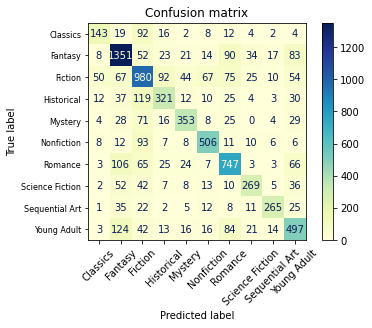

In [29]:
plot_cm(svm_pipeline, X_test, y_test)

In [36]:
svm_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k="all")),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC(C=1))  # learning algorithm
])

svm_pipeline.fit(X_train_tok, y_train)
pred = svm_pipeline.predict(X_test_tok)



In [40]:
predictions = svm_pipeline.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.71      0.49      0.58       302
        Fantasy       0.69      0.84      0.76      1693
        Fiction       0.66      0.59      0.63      1464
     Historical       0.60      0.57      0.59       573
        Mystery       0.73      0.65      0.69       538
     Nonfiction       0.81      0.74      0.77       667
        Romance       0.64      0.74      0.68      1049
Science Fiction       0.71      0.57      0.63       444
 Sequential Art       0.85      0.58      0.69       386
    Young Adult       0.56      0.60      0.58       830

       accuracy                           0.67      7946
      macro avg       0.70      0.64      0.66      7946
   weighted avg       0.68      0.67      0.67      7946

Confusion matrix:
[[ 147   17   81   17    2    8   21    5    2    2]
 [   6 1422   23   22   15   12   83   19   10   81]
 [  38  104  870  101   48   59  119   30    4   91]

In [41]:
eval_accuracy(predictions, y_test)

0.6744273848477221

In [42]:
param_grid = [{'sel__k': [3000, 5000, 7000,'all'], 'learner__C': [0.01, 0.1, 1, 10, 100]}]

opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  
    ('tfidf', TfidfTransformer()), 
    ('learner', LinearSVC())
])

n_jobs = 5 
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, cv=10, n_jobs = n_jobs, verbose=True).fit(X_train_tok,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:  3.1min finished


In [43]:
SVM_opt_search.best_params_


{'learner__C': 0.1, 'sel__k': 5000}

In [44]:
SVM_opt_search.best_estimator_


Pipeline(steps=[('sel',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x000001CC29916F70>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=0.1))])

In [45]:
opt_predictions = SVM_opt_search.best_estimator_.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.73      0.37      0.49       302
        Fantasy       0.70      0.86      0.77      1693
        Fiction       0.61      0.75      0.67      1464
     Historical       0.72      0.51      0.59       573
        Mystery       0.74      0.65      0.69       538
     Nonfiction       0.79      0.75      0.77       667
        Romance       0.69      0.75      0.72      1049
Science Fiction       0.79      0.56      0.65       444
 Sequential Art       0.89      0.58      0.70       386
    Young Adult       0.63      0.56      0.59       830

       accuracy                           0.69      7946
      macro avg       0.73      0.63      0.67      7946
   weighted avg       0.70      0.69      0.69      7946

Confusion matrix:
[[ 112   22  122   13    3   11   13    3    1    2]
 [   5 1459   34   12   20   13   77   12    9   52]
 [  22   73 1091   50   34   50   88   13    2   41]

In [46]:
eval_accuracy(y_test, opt_predictions)

0.6744273848477221

In [47]:
tokenizer = vect
selector = svm_pipeline.named_steps['sel']
classifier = svm_pipeline.named_steps['learner']

In [48]:
feature_names = tokenizer.get_feature_names()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

10000

In [57]:
feats_w_score[:100]

[(25.968331845846507, True, 'assumed'),
 (32.682159078210674, True, 'hung'),
 (37.56619437815321, True, 'believing'),
 (40.3191173950705, True, 'closest'),
 (40.645655805817476, True, 'second'),
 (42.519228411610314, True, 'end'),
 (43.47751954765393, True, 'fact'),
 (46.90939578723304, True, 'becoming'),
 (49.3543407683392, True, 'slow'),
 (51.42472324595287, True, 'given'),
 (53.25847621774601, True, 'while'),
 (56.966253220318045, True, 'newborn'),
 (58.44860353790502, True, 'striking'),
 (60.263214526135215, True, 'unrelenting'),
 (62.0859839031983, True, 'restless'),
 (62.80655378799001, True, 'damon'),
 (63.21917454162693, True, 'frustrated'),
 (65.59837044572541, True, 'dancing'),
 (66.04445548176822, True, 'picking'),
 (66.42963823274668, True, 'dancer'),
 (68.91740870664609, True, 'towards'),
 (69.24041831433156, True, 'confused'),
 (69.88590098927995, True, 'caused'),
 (70.55040014957787, True, 'luck'),
 (70.5511928687873, True, 'lack'),
 (71.66857963627648, True, 'promising'

In [50]:
feats_w_score[-100:]


[(4953.329723160099, True, 'lynley'),
 (4957.101646611778, True, 'forensic'),
 (4997.327434283741, True, 'maturin'),
 (5041.120217856892, True, 'calvin'),
 (5048.785909473804, True, 'morland'),
 (5107.899159109965, True, 'rebus'),
 (5126.04176125599, True, 'witherspoon'),
 (5206.443257745979, True, 'inspiring'),
 (5251.892569929472, True, 'zola'),
 (5295.180897318376, True, 'literature'),
 (5337.017513141499, True, 'viii'),
 (5416.272880080851, True, 'dumas'),
 (5416.815428400236, True, 'investigation'),
 (5423.534525264556, True, 'comic'),
 (5463.379339244511, True, 'introduction'),
 (5466.2247957576155, True, 'tempe'),
 (5476.898969953712, True, 'shaara'),
 (5501.270371398218, True, 'boleyn'),
 (5530.522367179654, True, 'karin'),
 (5545.601689548761, True, 'sexy'),
 (5551.02964542211, True, 'strangled'),
 (5582.3977729245225, True, 'colonists'),
 (5660.7596735778125, True, 'super'),
 (5672.07330634685, True, 'ender'),
 (5719.647850808964, True, 'scarpetta'),
 (5720.4545729332, True, 

In [51]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

9966

In [52]:
feats_w_classifier_weight[-100:]


[(0.9652589821047279, 'womanhood'),
 (0.9748861569355446, 'buck'),
 (0.9772679618116806, 'hemingway'),
 (0.9814062248654541, 'illuminate'),
 (0.9848298740290586, 'petersburg'),
 (0.985181078878724, 'fashioned'),
 (0.9861277588083028, 'developments'),
 (0.9900569825235703, 'reflects'),
 (0.9924630614106664, 'allegory'),
 (0.9932503598815557, 'classical'),
 (0.9988926523520036, '100'),
 (1.0064935370375183, 'orphan'),
 (1.0129103623157165, 'play'),
 (1.01293512397271, 'satirical'),
 (1.0162665955184407, 'edition'),
 (1.0199407923395576, 'achievement'),
 (1.025424864698142, 'numerous'),
 (1.0304316544539305, 'arabian'),
 (1.0318122004948451, 'buys'),
 (1.033053652963701, 'poe'),
 (1.0399896147879935, 'critical'),
 (1.0404716843463264, 'insanity'),
 (1.0488695124245608, 'louisa'),
 (1.0503294856803573, 'seminal'),
 (1.0583389098408504, 'commentary'),
 (1.0623143581871313, 'swashbuckling'),
 (1.0632803244395614, 'social'),
 (1.0661384380236572, 'annotated'),
 (1.0740881811192964, 'farming')

In [53]:
feats_w_classifier_weight[100:]


[(-0.5378208869944564, 'hotel'),
 (-0.5368966794133403, 'ago'),
 (-0.5363922363479187, 'irresistible'),
 (-0.5363852868270828, 'camps'),
 (-0.5361171565630399, 'anticipated'),
 (-0.5351776415033419, 'plates'),
 (-0.5338764843174549, 'clara'),
 (-0.533252673655714, 'side'),
 (-0.5314713209518168, 'breathes'),
 (-0.53120837011279, 'grandson'),
 (-0.5287210503705924, 'resonance'),
 (-0.5282129042530027, 'painting'),
 (-0.5274894141852506, 'younger'),
 (-0.5274559791588421, 'worship'),
 (-0.5267197197665336, 'tradition'),
 (-0.5238585453343894, 'renowned'),
 (-0.5236949059813054, 'unbridled'),
 (-0.5228992206091233, 'harriet'),
 (-0.5221369562380574, 'ties'),
 (-0.5211286741068983, 'hudson'),
 (-0.5207087527203923, 'descends'),
 (-0.5191645655246085, 'millions'),
 (-0.5184986206582923, 'canon'),
 (-0.5170470307563522, 'neurotic'),
 (-0.5166676767839347, 'mighty'),
 (-0.5157398839266693, 'cult'),
 (-0.515690778810128, 'hollywood'),
 (-0.515548092546082, 'funny'),
 (-0.5134894352632112, 'uno